<a href="https://colab.research.google.com/github/abhranil-datascience/DeepLearning/blob/ImageAnalytics/Day_4UnbalancedDatasetResnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
############################## Mount Drive ######################################## 
from google.colab import drive
drive.mount('/content/gdrive')

############################## Change Directory ###################################
import os
os.chdir('/content/gdrive/My Drive/ImageAnalytics/Day4-UnbalancedDatasetResnet/Dataset')

########## Suppress Warnings ############
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#################### Define Constant Folder Names and Get File Paths ###########################
DatasetDirectory='/content/gdrive/My Drive/ImageAnalytics/Day4-UnbalancedDatasetResnet/Dataset'
TrainingSet="training_set"
TestSet="test_set"
TrainingSetDirectory=DatasetDirectory+"/"+TrainingSet
TestSetDirectory=DatasetDirectory+"/"+TestSet
cat_directory="cats"
dog_directory="dogs"
TrainingSetCatDirectory=TrainingSetDirectory+"/"+cat_directory
TrainingSetDogDirectory=TrainingSetDirectory+"/"+dog_directory
TestSetCatDirectory=TestSetDirectory+"/"+cat_directory
TestSetDogDirectory=TestSetDirectory+"/"+dog_directory
FilePathsCatTrainingSet=[TrainingSetCatDirectory+"/"+fname for fname in os.listdir(TrainingSetCatDirectory) if '.jpg' in fname]
FilePathsDogTrainingSet=[TrainingSetDogDirectory+"/"+fname for fname in os.listdir(TrainingSetDogDirectory) if '.jpg' in fname]
FilePathsCatTestSet=[TestSetDirectory+"/"+fname for fname in os.listdir(TestSetCatDirectory) if '.jpg' in fname]
FilePathsDogTestSet=[TestSetDirectory+"/"+fname for fname in os.listdir(TestSetDogDirectory) if '.jpg' in fname]
TrainingSetFilePaths=FilePathsCatTrainingSet+FilePathsDogTrainingSet
TestSetFilePaths=FilePathsCatTestSet+FilePathsDogTestSet
import random
random.shuffle(TrainingSetFilePaths)
print("Number Of Training Set Cats: "+str(len(FilePathsCatTrainingSet))+ " || "+ 
      "Number Of Training Set Dogs: "+str(len(FilePathsDogTrainingSet))+ " || "+ 
      "Number of Training Set Images: "+str(len(TrainingSetFilePaths)))
print("")
print("Number Of Test Set Cats: "+str(len(FilePathsCatTestSet))+ " || "+ 
      "Number Of Test Set Dogs: "+str(len(FilePathsDogTestSet))+ " || "+ 
      "Number of Test Set Images: "+str(len(TestSetFilePaths)))

Number Of Training Set Cats: 3928 || Number Of Training Set Dogs: 1000 || Number of Training Set Images: 4928

Number Of Test Set Cats: 1000 || Number Of Test Set Dogs: 201 || Number of Test Set Images: 1201


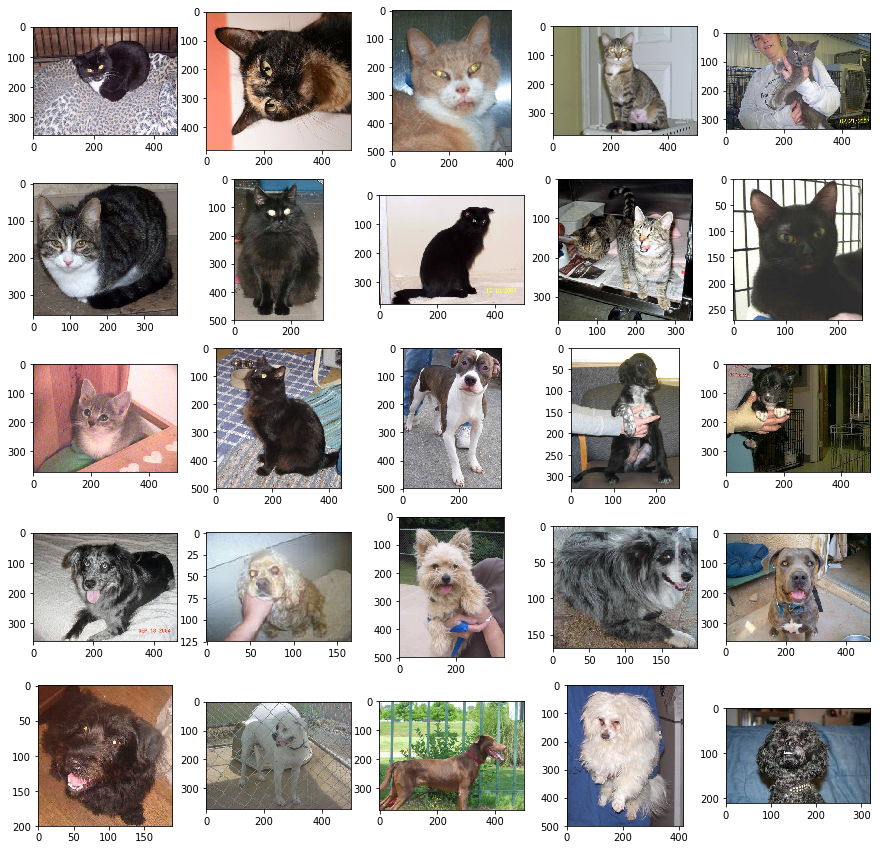

In [0]:
##################################### Visualize Data Set ##################################################
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig=plt.figure(figsize=(15,15))
columns = 5
rows = 5
import random
random.shuffle(FilePathsCatTrainingSet)
random.shuffle(FilePathsDogTrainingSet)
for count in range(0,25):
  if count < 12:
    img=mpimg.imread(FilePathsCatTrainingSet[count])
    fig.add_subplot(rows, columns, count+1)
  else:
    img=mpimg.imread(FilePathsDogTrainingSet[count])
    fig.add_subplot(rows, columns, count+1)
  imgplot = plt.imshow(img)
plt.show()

In [0]:
#################### Create Image Generator and Preprocess ################################################
from keras.preprocessing.image import ImageDataGenerator
train_image_generator=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,vertical_flip=True)
test_image_generator=ImageDataGenerator(rescale=1./255)
training_set=train_image_generator.flow_from_directory(directory=TrainingSet,target_size=(224,224),classes=['cats','dogs'],class_mode='binary',batch_size=64, shuffle=True)
#training_set.class_indices ==> {'cats': 0, 'dogs': 1}
test_set=test_image_generator.flow_from_directory(directory=TestSetDirectory,target_size=(224,224),classes=['cats','dogs'],class_mode='binary',batch_size=64, shuffle=True)
#test_set.class_indices ==> {'cats': 0, 'dogs': 1}

Using TensorFlow backend.


Found 4928 images belonging to 2 classes.
Found 1201 images belonging to 2 classes.


In [0]:
################################### Create Functions to use F1-Score as metrics in Keras ##########################################
from keras import backend as K
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
#################################################### Create Callbacks ###########################################################
BestModel="/content/gdrive/My Drive/ImageAnalytics/Day4-UnbalancedDatasetResnet/BestModel/best_model.hdf5"
from keras.callbacks import ModelCheckpoint,EarlyStopping
save_best_model=ModelCheckpoint(filepath=BestModel,monitor='val_f1_m',save_best_only=True,mode='max',verbose=2)
early_stopping=EarlyStopping(monitor='val_acc',min_delta=0.003,patience=25,mode='max',restore_best_weights=True,verbose=2)

In [0]:
################################################## Import Reset50 Model ###################################################################
import warnings
warnings.filterwarnings('ignore')
from keras.applications import resnet50 as r50
base_model=r50.ResNet50(weights=None,include_top=False,input_shape=(224,224,3))
from keras.layers import Input,AveragePooling2D,Flatten,Dense
from keras.models import Model
X_Input=Input(shape=(224,224,3),name='main_input')
X=base_model(X_Input)
X=AveragePooling2D(pool_size=(7,7), padding='same')(X)
X=Flatten()(X)
output=Dense(units=1,activation='sigmoid')(X)
model=Model(inputs=X_Input,outputs=output)
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc',f1_m])
model.summary()










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
########################### Fit Generator ###################################
"""
Since we have class imbalance so we will use class weights parameter to handle unbalanced class
We will create a dictionary representing the weights of each class
Number of cats in training set is almost 4000 whereas number of dogs in training set is 1000
so class weight will be 
class_weight:{0:1,1:4}
"""
class_weight={0:1,1:4}
model.fit_generator(generator=training_set,steps_per_epoch=4928/64,epochs=100,callbacks=[save_best_model,early_stopping],
                    validation_data=test_set,validation_steps=1201/64,shuffle=True,class_weight=class_weight)

Epoch 1/100
77/77 [==============================] - 1614s 21s/step - loss: 1.4450 - acc: 0.5875 - f1_m: 0.3456 - val_loss: 1.0899 - val_acc: 0.6811 - val_f1_m: 0.2195

Epoch 00001: val_f1_m improved from -inf to 0.21952, saving model to /content/gdrive/My Drive/ImageAnalytics/Day4-UnbalancedDatasetResnet/BestModel/best_model.hdf5
Epoch 2/100
77/77 [==============================] - 136s 2s/step - loss: 1.0990 - acc: 0.6272 - f1_m: 0.3791 - val_loss: 1.8481 - val_acc: 0.6170 - val_f1_m: 0.2118

Epoch 00002: val_f1_m did not improve from 0.21952
Epoch 3/100
77/77 [==============================] - 135s 2s/step - loss: 1.0451 - acc: 0.6587 - f1_m: 0.4210 - val_loss: 0.8513 - val_acc: 0.4421 - val_f1_m: 0.3320

Epoch 00003: val_f1_m improved from 0.21952 to 0.33204, saving model to /content/gdrive/My Drive/ImageAnalytics/Day4-UnbalancedDatasetResnet/BestModel/best_model.hdf5
Epoch 4/100
77/77 [==============================] - 135s 2s/step - loss: 1.0421 - acc: 0.6642 - f1_m: 0.4236 - val

In [0]:
################################## Test on New Images ########################################
from keras.models import load_model
best_model=load_model(BestModel,custom_objects={'recall_m':recall_m,'precision_m':precision_m,'f1_m':f1_m})
PredictionDirectory='/content/gdrive/My Drive/ImageAnalytics/Day1-CNN/Test/Images'
import numpy as np
from skimage.io import imread
from skimage.transform import resize
for img in os.listdir(PredictionDirectory):
  img_path=PredictionDirectory+"/"+img
  curr_img=imread(img_path)
  curr_img_resized=resize(curr_img,output_shape=(224,224))
  curr_img=np.expand_dims(curr_img_resized,axis=0)
  curr_pred=best_model.predict(curr_img)
  if curr_pred > 0.5:
    print("Filename: "+img+" || Prediction: Dog")
  else:
    print("Filename: "+img+" || Prediction: Cat")

Filename: Picture1_cat.jpg || Prediction: Cat
Filename: Picture6_dog.jpg || Prediction: Dog
Filename: Picture2_cat.jpg || Prediction: Cat
Filename: Picture3_cat.jpg || Prediction: Cat
Filename: Picture4_dog.jpg || Prediction: Dog
Filename: Picture5_dog.jpg || Prediction: Dog
